In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("StudyEventTimeSeries.csv")

In [2]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [3]:
actionOnly= list(filter(lambda x: x.isupper(),codelist))
featureOnly= list(filter(lambda x: x.islower(),codelist))

In [4]:
# df["t"]=df.index

In [5]:
df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

In [6]:
import altair as alt

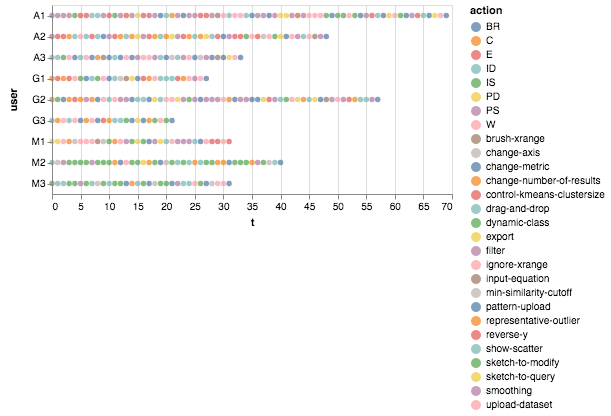

In [7]:
alt.Chart(df).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

# Action only

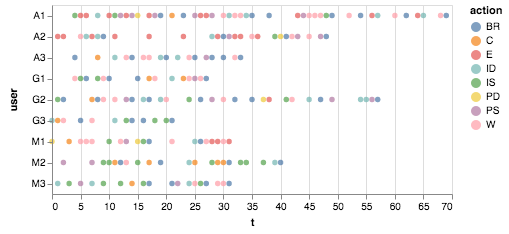

In [8]:
df_action = df[df.action.isin(actionOnly)]
alt.Chart(df_action).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

# Feature Only

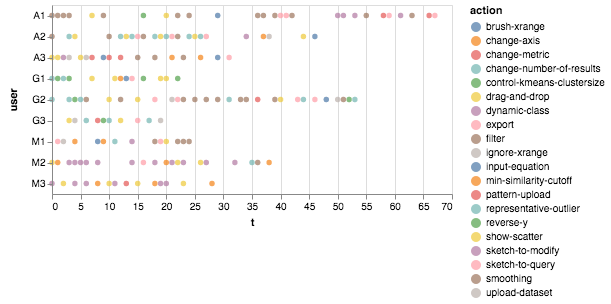

In [9]:
df_feature = df[df.action.isin(featureOnly)]
alt.Chart(df_feature).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

In [10]:
# df_feature = df[~df.action.isin(featureOnly)]

# Key Components

In [11]:
component_dict = {
     'pattern-upload':'concept-query',
     'sketch-to-modify':'exact-specification',
     'drag-and-drop':'result-querying',
     'change-metric':'flexible-matching',
     'filter':'filter-selection',
     'brush-xrange':'range-selection',
     'min-similarity-cutoff':'control',
     'smoothing':'approx-shape-specification',
     'ignore-xrange':'approx-shape-specification',
     'representative-outlier':'recommendation',
     'dynamic-class':'group-comparison',
     'sketch-to-query':'exact-specification',
     'reverse-y':'control',
     'input-equation':'exact-specification',
     'upload-dataset':'control',
     'show-scatter':'control',
     'export':'control',
     'change-number-of-results':'control',
     'control-kmeans-clustersize':'recommendation',
     'change-axis':'control'
}

In [12]:
df_component = df_feature
df_component["action"] = df_feature["action"].replace(component_dict)
df_component= df_component.rename(index=str,columns={"action":"component"})

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
# df_component = df_component[df_component["component"]!="control"] #remove control in list of components

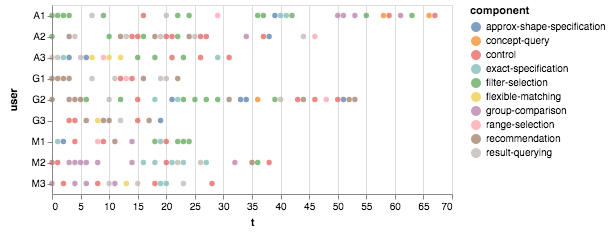

In [14]:
alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

# Adding some event action information back in

In [15]:
component_chart = alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

In [16]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_break).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [17]:
df_insight = df[df.action.isin(["IS","ID"])]
df_insight.loc[df_insight["action"]=="ID","action"]="data insight"
df_insight.loc[df_insight["action"]=="IS","action"]="scientific insight"
insight_chart = alt.Chart(df_insight).mark_point(shape="diamond",color="red").encode(        
    alt.Y("user",title="Participant"),
    alt.X("t",title="Timepoint"),
    shape='action' #make no distinction between data and science insights
)


/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


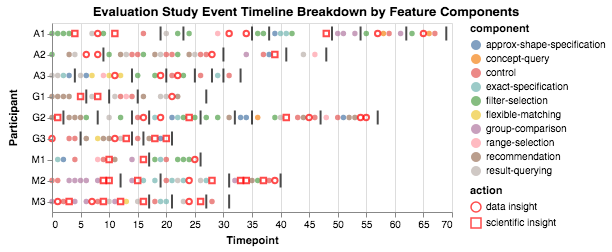

In [18]:
chart = component_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Feature Components"
chart

- Astronomers discovered insights more about their data, whereas geneticists and material scientists uncovered more scientific insights.
- The use of exact specification (including sketch) is rare, and doesn't usually lead to useful outcomes. 

# Processes

In [19]:
df_component["component"].unique()

array(['filter-selection', 'result-querying', 'recommendation', 'control',
       'group-comparison', 'exact-specification',
       'approx-shape-specification', 'flexible-matching',
       'range-selection', 'concept-query'], dtype=object)

In [20]:
td = '1-top-down-querying'
sc = '2-search-with-context'
bu = '3-bottom-up-querying'
rec= '4-recommendation'
component_to_process = {
    'exact-specification':td,
    'approx-shape-specification':td,
    'flexible-matching':td,
    'range-selection':td, 
    'filter-selection':sc, 
    'group-comparison':sc,
    'result-querying':bu,
    'concept-query':bu,
    'control':"others",
    'recommendation':rec,
}

In [21]:
df_process = df_component
df_process["process"] = df_component["component"].replace(component_to_process)

In [22]:
process_chart = alt.Chart(df_component).mark_circle().encode(        
    color='process',
    y="user",
    x='t'
)

In [23]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_break).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [24]:
df_insight = df[df.action.isin(["IS","ID"])]
df_insight.loc[df_insight["action"]=="ID","action"]="data insight"
df_insight.loc[df_insight["action"]=="IS","action"]="scientific insight"
insight_chart = alt.Chart(df_insight).mark_point(shape="diamond",color="red").encode(        
    alt.Y("user",title="Participant"),
    alt.X("t",title="Timepoint"),
    shape='action' #make no distinction between data and science insights
)


/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


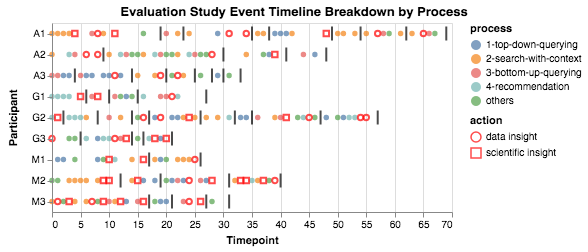

In [25]:
chart = process_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Process"
chart

- Top-down querying alone does not lead to insights. We see a lot of sessions where people try top-down querying then give up without discovering an insight. Even when there is top-down querying performed sucessfully, it is often because it was associated with a search with context, or used for sketch modification on a drag-and-dropped visualization.

# Statistics

In [26]:
print ("Total number of sessions:", len(df[df["action"]=="BR"]))

Total number of sessions: 46


In [27]:
df = pd.read_csv("StudyEventTimeSeries.csv")

df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"Feature"
})

In [28]:
df = df[df.Feature.isin(featureOnly)]

In [29]:
df['subject'] = df['user'].apply(lambda x: {'A':'astro', 'G':'genetics', 'M':'material science'}[x[0]])

In [30]:
df_frequency_by_subject_feature = df.groupby(["subject","Feature"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

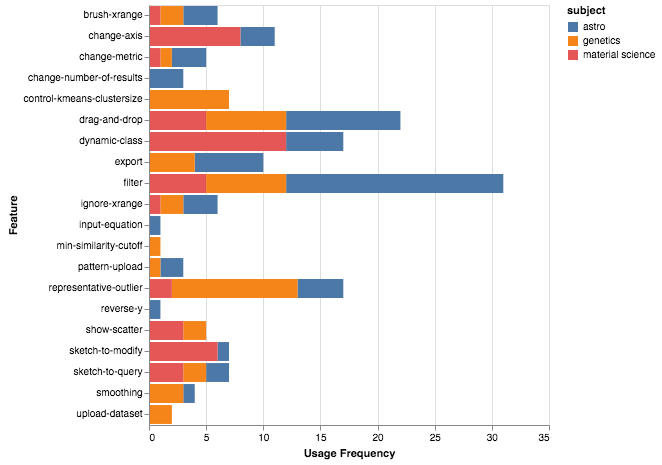

In [31]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    alt.X("Usage Frequency"),
    alt.Y("Feature"),
    color = "subject"
)

In [32]:
df_component = df
df_component["Component"] = df["Feature"].replace(component_dict)

In [33]:
df_frequency_by_subject_feature = df.groupby(["subject","Component"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

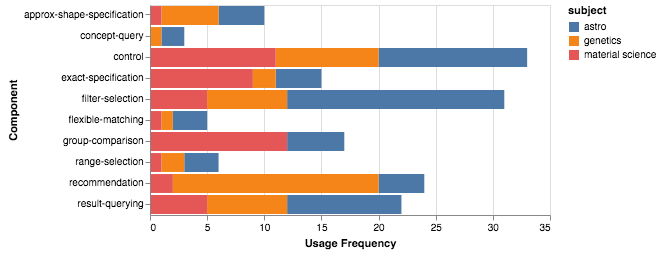

In [34]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    alt.X("Usage Frequency"),
    alt.Y("Component"),
    color = "subject"
)

In [35]:
df_process = df_component
df_process["Process"] = df_component["Component"].replace(component_to_process)

In [36]:
df_frequency_by_subject_feature = df.groupby(["subject","Process"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

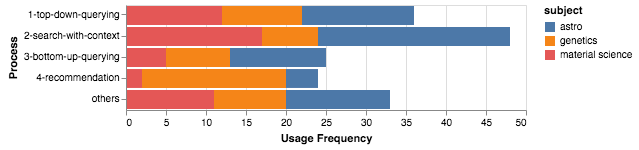

In [37]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    alt.X("Usage Frequency"),
    alt.Y("Process"),
    color = "subject"
)

Most of the contribution of top-down querying is coming from changing metric, brush x-range, ignore-xrange, not just the sketching portion. 

In [46]:
df_process[df_process["Process"]=="1-top-down-querying"].groupby("Feature").count()["user"]

Feature
brush-xrange        6
change-metric       5
ignore-xrange       6
input-equation      1
sketch-to-modify    7
sketch-to-query     7
smoothing           4
Name: user, dtype: int64

# Compiling everything into sessions

In [49]:

df = pd.read_csv("StudyEventTimeSeries.csv")
sessions=[]
for row in df.as_matrix().T: 
    session=[]
    for action in row:
        if action is not np.NaN:
            if action=="BR":
                if session!=[]:
                    sessions.append(session)
                session=[]
            else:
                session.append(action)
    if session!=[]:
        sessions.append(session)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [50]:
#Overall Counts
from collections import Counter
overall_sessions_flat  = [item for sublist in sessions  for item in sublist]

In [51]:
overall_sessions_flat_filtered  =list(filter(lambda x: x in featureOnly, overall_sessions_flat)) #filter out action codes with capital letters

In [52]:
x = Counter(overall_sessions_flat_filtered)
frequency = x.most_common()
frequency.append(("error-bar",0))

In [53]:
df = pd.DataFrame(frequency,columns=["feature","usage frequency"])

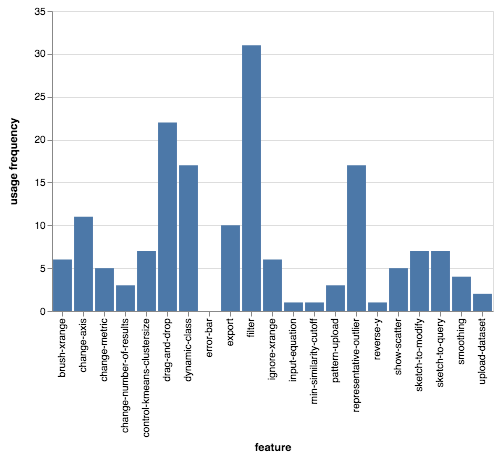

In [54]:
alt.Chart(df).mark_bar().encode(
    alt.X("feature"),
    alt.Y("usage frequency")
)

In [55]:
print ("Number of sessions with at least one insight:", len(list(filter(lambda x: ('IS' in x) or ('ID' in x),sessions))) )

Number of sessions with at least one insight: 30


In [56]:
insightful_sessions = list(filter(lambda x: ('IS' in x) or ('ID' in x),sessions))

In [57]:
insightful_sessions_flat  = [item for sublist in insightful_sessions  for item in sublist]

In [58]:
x = Counter(insightful_sessions_flat)
x.most_common()

[('W', 30),
 ('IS', 26),
 ('ID', 25),
 ('filter', 24),
 ('E', 21),
 ('drag-and-drop', 16),
 ('PS', 15),
 ('dynamic-class', 14),
 ('representative-outlier', 14),
 ('C', 11),
 ('change-axis', 8),
 ('sketch-to-query', 7),
 ('export', 7),
 ('control-kmeans-clustersize', 6),
 ('PD', 5),
 ('ignore-xrange', 5),
 ('change-metric', 5),
 ('show-scatter', 5),
 ('brush-xrange', 4),
 ('sketch-to-modify', 4),
 ('pattern-upload', 3),
 ('change-number-of-results', 3),
 ('smoothing', 2),
 ('upload-dataset', 2),
 ('reverse-y', 1)]